In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import astropy.units as u

In [14]:
from gammapy.maps import MapAxis
from gammapy.modeling import Fit

from astropy.coordinates import SkyCoord

import ogip_spectrum_dataset

In [2]:
filename = "../example_files/xmm/PN_PWN.grp"

pn_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)
#filename = "../example_files/xmm/"
#mos1_dataset = StandardOGIPDatasetReader(filename).read()
#filename = "../example_files/xmm/MOS2_PWN.grp"
#mos2_dataset = StandardOGIPDatasetReader(filename).read()

(1.0, 10.0)

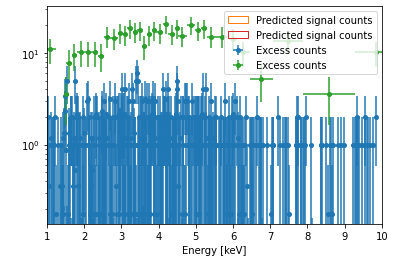

In [5]:
ax = pn_dataset.plot_excess()
ax = pn_dataset.grouped.plot_excess()
#mos1_dataset.plot_excess(ax=ax)
#mos2_dataset.plot_excess(ax=ax)
plt.xlim(1,10)

In [3]:
from gammapy.modeling.models import SpectralModel, Parameter


class WAbsSpectralModel(SpectralModel):
    tag = "WAbsSpectralModel"
    NH = Parameter("NH", "2.1e18 cm-2", min=0)
   
    @staticmethod
    def cross_section(energy):
        edges =  [0.030,  0.100, 0.284, 0.400, 0.532, 0.707, 0.867, 1.303, 1.840, 2.471, 3.210, 4.038, 7.111, 8.331, 10, 11]*u.keV   # 1 more edge
        axis = MapAxis.from_edges(edges, name="energy_true", interp="lin")
 
        c0 = np.array([17.3, 34.6, 78.1, 71.4, 95.5, 308.9, 120.6, 141.3, 202.7, 342.7, 352.2, 433.9, 629.0, 701.2])
        c1=np.array([608.1, 267.9, 18.8, 66.8, 145.8, -380.6, 169.3, 146.8, 104.7, 18.7, 18.7, -2.4, 30.9, 25.2])
        c2=np.array([-2150., -476.1, 4.3, -51.4, -61.1, 294.0, -47.7, -31.5, -17.0, 0.0, 0,0, 0.75, 0.0, 0.0])
  
        indices = axis.coord_to_idx(energy)
        indices = np.clip(indices, 0, 13)
        
        e_no_unit = energy.to_value("keV")
        cross_section = (c0[indices] + c1[indices]*e_no_unit  + c2[indices]*e_no_unit**2)
        cross_section *= e_no_unit**-3
        cross_section = cross_section*1e-24*u.cm**2
     
        return cross_section

    @staticmethod
    def evaluate(energy, NH):
        sigma = WAbsSpectralModel.cross_section(energy) 
        return np.exp(-sigma*NH)

In [4]:
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
pl = PowerLawSpectralModel(reference="1 keV", amplitude="1e-3 cm-2s-1 keV-1")
wabs = WAbsSpectralModel(NH="2.1e22 cm-2")

spectral_model = wabs*pl

<AxesSubplot:xlabel='Energy [keV]', ylabel='dnde [1 / (cm2 s TeV)]'>

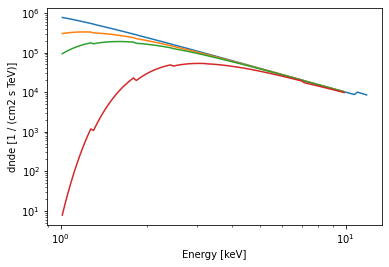

In [8]:
spectral_model.parameters["NH"].value=1e21
spectral_model.plot(energy_bounds=[1, 12]*u.keV)
spectral_model.parameters["NH"].value=5e21
spectral_model.plot(energy_bounds=[1, 10]*u.keV)
spectral_model.parameters["NH"].value=10e21
spectral_model.plot(energy_bounds=[1, 10]*u.keV)
spectral_model.parameters["NH"].value=50e21
spectral_model.plot(energy_bounds=[1, 10]*u.keV)

In [9]:
spectral_model.parameters["amplitude"].min=0

In [10]:
model = SkyModel(spectral_model=spectral_model)

In [11]:
from gammapy.datasets import Datasets
xmm_datasets = Datasets([pn_dataset])#, mos1_dataset, mos2_dataset])
xmm_datasets.models=[model]

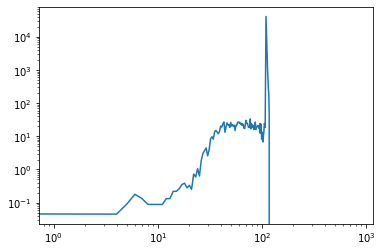

In [12]:
plt.loglog(np.squeeze(pn_dataset.npred_signal().data))

In [13]:
spectral_model.parameters["NH"].value = 4e22
spectral_model.parameters["index"].value = 1.8
spectral_model.parameters["amplitude"].value = 1e5

In [14]:
pn_dataset.grouped.models

In [15]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

CPU times: user 39.5 s, sys: 2.35 ms, total: 39.5 s
Wall time: 39.5 s


In [16]:
print(fit_result.parameters.to_table())

  type      name     value         unit        error      min    max frozen link
-------- --------- ---------- -------------- --------- --------- --- ------ ----
spectral        NH 1.2121e+22           cm-2 2.075e+21 0.000e+00 nan  False     
spectral     index 4.4232e-01                1.640e-01       nan nan  False     
spectral amplitude 4.5723e-05 cm-2 keV-1 s-1 1.141e-05 0.000e+00 nan  False     
spectral reference 1.0000e+00            keV 0.000e+00       nan nan   True     


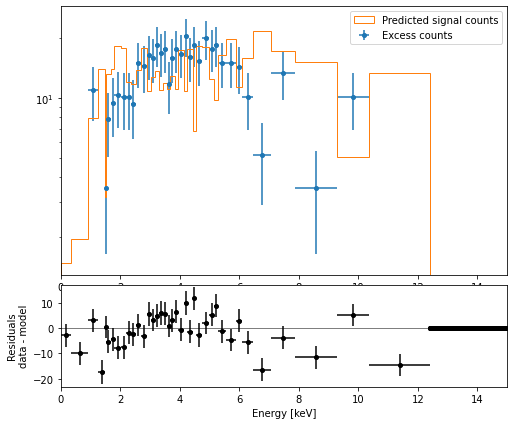

In [17]:
pn_dataset.plot_fit()

<AxesSubplot:xlabel='Energy [keV]', ylabel='Residuals (data - model)'>

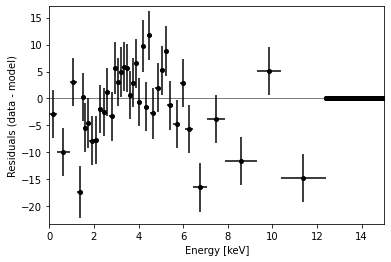

In [18]:
pn_dataset.plot_residuals_spectral()

In [16]:
pn_dataset.mask_fit = pn_dataset.counts.geom.energy_mask(5*u.keV, 10*u.keV)

In [17]:
pn_dataset.mask_fit

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (1, 1, 840)
	ndim  : 3
	unit  : 
	dtype : bool

In [18]:
fit = Fit()
fit_result = fit.run(xmm_datasets)

In [19]:
print(fit_result.parameters.to_table())

  type      name     value         unit        error      min    max frozen link
-------- --------- ---------- -------------- --------- --------- --- ------ ----
spectral        NH 5.7879e+16           cm-2 2.353e+20 0.000e+00 nan  False     
spectral     index 1.4188e+00                4.485e-01       nan nan  False     
spectral amplitude 2.1651e-04 cm-2 keV-1 s-1 1.806e-04 0.000e+00 nan  False     
spectral reference 1.0000e+00            keV 0.000e+00       nan nan   True     


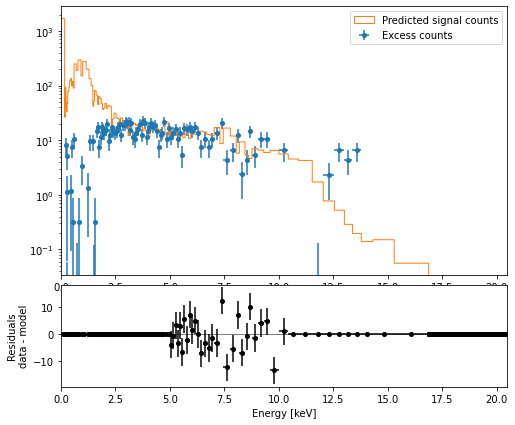

In [20]:
pn_dataset.plot_fit()